In [5]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [6]:
import requests
import re
import os
import zipfile
import collections
import urllib.request
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML
from collections import defaultdict
import time
import random

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score


In [7]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.11.0
keras version 2.11.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Reading the data

In [8]:
%%capture
# !unzip "./all_data/sep_1/data.zip" -d "./temp_data/sep_1/"

In [9]:
# Getting the folder names 
folder_names = glob.glob("./temp_data/sep_1/data/*")

In [10]:
# Getting the data names
data_names = []
for i in folder_names:
    data_names.append(glob.glob(i+"/*.csv"))

## Data Loading

In [11]:
# Datasets to skip 
skip = []

# Labels of the datasets
labels = []

# Data list 
data = []


# Getting the labels and data for each dataset
for i in range(len(data_names)):
    if i in skip:
        continue
    
    for j in range(len(data_names[i])):
        labels.append([data_names[i][j][data_names[i][j].find(".csv")-1]])
        
        # Cleaning data
        df = pd.read_csv(data_names[i][j],skiprows = 1)
        df.drop(columns=df.columns[-1], axis=1,  inplace=True)
        
        data.append(df)

In [12]:
# Changing the labels from int to string
labels = [int(i)-1 for i in np.reshape(labels,(-1,))]

In [13]:
# Targets for sep_1
target = np.array([[-0.314,1.661,0.45],[0,1.661,0.45],[0.314,1.661,0.45],[-0.314,1.347,0.45],[0,1.347,0.45],[0.314,1.347,0.45],[-0.314,1.033,0.45],[0,1.033,0.45],[0.314,1.033,0.45]])

In [36]:
target/2

array([[-0.157 ,  0.8305,  0.225 ],
       [ 0.    ,  0.8305,  0.225 ],
       [ 0.157 ,  0.8305,  0.225 ],
       [-0.157 ,  0.6735,  0.225 ],
       [ 0.    ,  0.6735,  0.225 ],
       [ 0.157 ,  0.6735,  0.225 ],
       [-0.157 ,  0.5165,  0.225 ],
       [ 0.    ,  0.5165,  0.225 ],
       [ 0.157 ,  0.5165,  0.225 ]])

In [14]:
labels_3d = [target[i] for i in labels]

## Adding Features

In [15]:
# Adding the centroid of all the fingers to the data

new_data = []

for idx_1 in range(len(data)):

    
    # Grouped columns for centroid
    grouped_columns_x = data[idx_1].columns[3::3] 
    grouped_columns_y = data[idx_1].columns[4::3]
    grouped_columns_z = data[idx_1].columns[5::3]
    
    # Getting the centroid of the finger points
    cent_x = np.mean(data[idx_1][grouped_columns_x],axis = 1)
    cent_y = np.mean(data[idx_1][grouped_columns_y],axis = 1)
    cent_z = np.mean(data[idx_1][grouped_columns_z],axis = 1)
    
    new_data.append(pd.concat([data[idx_1],cent_x,cent_y,cent_z],axis = 1))
    

## Data Cleaning

In [16]:
# Pulling only the centroid data 
cent_data = [i.iloc[:,-3:] for i in new_data]

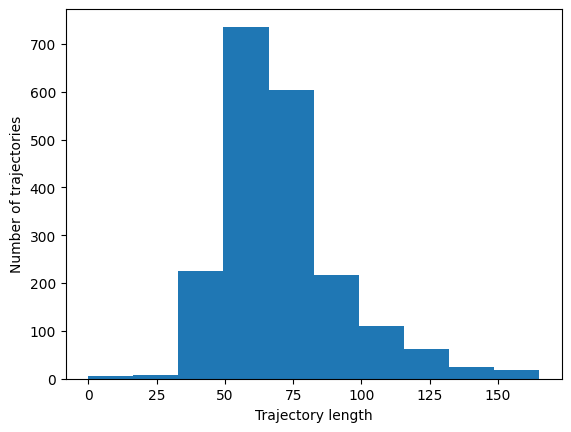

In [17]:
lengths = np.array([len(i) for i in cent_data])
plt.hist(lengths)
plt.xlabel("Trajectory length")
plt.ylabel("Number of trajectories");

In [18]:
# Removing trajectories with <=5 length
idx = np.where(lengths <= 5.)[0]
[labels.pop(j-i) for i,j in enumerate(idx)]
[labels_3d.pop(j-i) for i,j in enumerate(idx)]
[cent_data.pop(j-i) for i,j in enumerate(idx)];

In [19]:
# Checking to see if it worked 
lengths = np.array([len(i) for i in cent_data])
np.where(lengths <= 5.)

(array([], dtype=int64),)

In [20]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(cent_data, labels, test_size=0.2)
# x_train, x_test, y_train, y_test = train_test_split(cent_data, labels_3d, test_size=0.2)

## Data Augmentation

In [21]:
x_train_aug = []
for idx,i in enumerate(x_train):
    ch = np.random.choice([0,1],p = [0.3,0.7])

    flag = 0 

    if ch == 0: # Perform data augmentation

        trim = len(i)//2

        if trim >= 5: # Trim if the lengths are greater than 5

            aug = i.head(trim)

        else: # If lengths are not greater than 1, don't trim

            aug = i
    else:
        aug = i


    x_train_aug.append(aug)


In [22]:
# Printing out the lengths after and before augmentation
len(x_train_aug), len(x_train)

(1605, 1605)

## Data Formatting

In [23]:
# Getting the data in the required format for the model
# Creating labels for RNN's output 
y_train = [[dt]*200 for idx,dt in enumerate(y_train)]
y_test = [[dt]*200 for idx,dt in enumerate(y_test)]

In [24]:
# Sequence length is based on data analysis
x_train = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', dtype='float', maxlen=200))
y_train = tf.convert_to_tensor(y_train)

x_test = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', dtype='float', maxlen=200))
y_test = tf.convert_to_tensor(y_test)

In [25]:
# One hot encoding the data for training - not required for label_3d
y_train = tf.one_hot(y_train, 9, on_value = 1.0, off_value = 0.0)
y_test = tf.one_hot(y_test, 9, on_value = 1.0, off_value = 0.0)

## Models

### Creating the RNN model

In [26]:
hidden_size= 10
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')


ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN_1(ip_reformed)

RNN_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_2 = RNN_2(h_1)


dense_2 = tf.keras.layers.Dense(9, activation='softmax')
output = dense_2(h_2)

model_RNN = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=tf.keras.optimizers.Adam(1e-2))

### Creating the RNN model - labels_3d

In [27]:
hidden_size= 10
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')


ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN_1(ip_reformed)

RNN_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_2 = RNN_2(h_1)


dense_2 = tf.keras.layers.Dense(3, activation='linear')
output = dense_2(h_2)

model_RNN_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_3d.compile(loss='mse', metrics = ['mse'], optimizer=tf.keras.optimizers.Adam(1e-2))

### Creating the LSTM model

In [28]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h = LSTM(ip_reformed)

dense = tf.keras.layers.Dense(9, activation='softmax')
output = dense(h)

model_LSTM = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_LSTM.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=tf.keras.optimizers.Adam(1e-2))

### Creating the LSTM model - labels_3d

In [29]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h = LSTM(ip_reformed)

dense = tf.keras.layers.Dense(3, activation='linear')
output = dense(h)

model_LSTM_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_LSTM_3d.compile(loss='mse', metrics = ['mse'])

### Creating the LSTM+RNN model

In [30]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN(ip_reformed)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h_2 = LSTM(h_1)

dense = tf.keras.layers.Dense(9, activation='softmax')
output = dense(h_2)

model_RNN_LSTM = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_LSTM.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=tf.keras.optimizers.Adam(1e-2))

### Creating the LSTM+RNN model - labels_3d

In [31]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN(ip_reformed)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h_2 = LSTM(h_1)

dense = tf.keras.layers.Dense(3, activation='linear')
output = dense(h_2)

model_RNN_LSTM_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_LSTM_3d.compile(loss='mse', metrics = ['mse'])

In [32]:
model_RNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 3)]          0         
                                                                 
 dense (Dense)               (None, 200, 10)           40        
                                                                 
 simple_rnn (SimpleRNN)      (None, 200, 10)           210       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 200, 10)           210       
                                                                 
 dense_1 (Dense)             (None, 200, 9)            99        
                                                                 
Total params: 559
Trainable params: 559
Non-trainable params: 0
_________________________________________________________________


In [33]:
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=100,
    restore_best_weights = True
)

In [34]:
history = model_RNN.fit(x_train,y_train, epochs=1000, batch_size=16, validation_split=0.2,callbacks = [callbacks])

Epoch 1/1000


2022-12-11 19:19:56.136243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-11 19:19:56.410201: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1455680123d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-11 19:19:56.410228: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2022-12-11 19:19:56.415177: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-11 19:19:56.810981: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 [==============================] - 21s 179ms/step - loss: 2.1900 - accuracy: 0.1224 - val_loss: 2.1549 - val_accuracy: 0.1433
Epoch 2/1000
81/81 [==============================] - 14s 175ms/step - loss: 2.1506 - accuracy: 0.1431 - val_loss: 2.1636 - val_accuracy: 0.1503
Epoch 3/1000
81/81 [==============================] - 14s 176ms/step - loss: 2.1434 - accuracy: 0.1446 - val_loss: 2.1231 - val_accuracy: 0.1699
Epoch 4/1000
81/81 [==============================] - 14s 169ms/step - loss: 2.1298 - accuracy: 0.1621 - val_loss: 2.1229 - val_accuracy: 0.1607
Epoch 5/1000
81/81 [==============================] - 14s 168ms/step - loss: 2.1317 - accuracy: 0.1545 - val_loss: 2.1372 - val_accuracy: 0.1423
Epoch 6/1000
81/81 [==============================] - 14s 169ms/step - loss: 2.1251 - accuracy: 0.1575 - val_loss: 2.1241 - val_accuracy: 0.1716
Epoch 7/1000
81/81 [==============================] - 14s 167ms/step - loss: 2.1218 - accuracy: 0.1795 - val_loss: 2.1310 - val_accuracy: 0.159

81/81 [==============================] - 14s 168ms/step - loss: 1.5789 - accuracy: 0.2770 - val_loss: 1.4821 - val_accuracy: 0.3133
Epoch 58/1000
81/81 [==============================] - 14s 167ms/step - loss: 1.4920 - accuracy: 0.2883 - val_loss: 1.4747 - val_accuracy: 0.2917
Epoch 59/1000
81/81 [==============================] - 14s 168ms/step - loss: 1.4531 - accuracy: 0.2922 - val_loss: 1.4399 - val_accuracy: 0.2974
Epoch 60/1000
81/81 [==============================] - 14s 170ms/step - loss: 1.4450 - accuracy: 0.2916 - val_loss: 1.4406 - val_accuracy: 0.2769
Epoch 61/1000
81/81 [==============================] - 14s 177ms/step - loss: 1.4367 - accuracy: 0.2958 - val_loss: 1.4150 - val_accuracy: 0.3220
Epoch 62/1000
81/81 [==============================] - 15s 183ms/step - loss: 1.4279 - accuracy: 0.2940 - val_loss: 1.4127 - val_accuracy: 0.3291
Epoch 63/1000
81/81 [==============================] - 15s 184ms/step - loss: 1.4337 - accuracy: 0.2995 - val_loss: 1.4080 - val_accuracy:

81/81 [==============================] - 15s 185ms/step - loss: 2.1104 - accuracy: 0.1895 - val_loss: 2.1104 - val_accuracy: 0.1923
Epoch 114/1000
81/81 [==============================] - 15s 185ms/step - loss: 2.1107 - accuracy: 0.1834 - val_loss: 2.1084 - val_accuracy: 0.1877
Epoch 115/1000
81/81 [==============================] - 15s 188ms/step - loss: 2.1169 - accuracy: 0.1837 - val_loss: 2.1156 - val_accuracy: 0.1910
Epoch 116/1000
81/81 [==============================] - 15s 185ms/step - loss: 2.1051 - accuracy: 0.1902 - val_loss: 2.1071 - val_accuracy: 0.1890
Epoch 117/1000
81/81 [==============================] - 15s 185ms/step - loss: 2.0981 - accuracy: 0.1928 - val_loss: 2.0991 - val_accuracy: 0.1957
Epoch 118/1000
81/81 [==============================] - 15s 187ms/step - loss: 2.1231 - accuracy: 0.1723 - val_loss: 2.1408 - val_accuracy: 0.1541
Epoch 119/1000
81/81 [==============================] - 16s 194ms/step - loss: 2.1310 - accuracy: 0.1723 - val_loss: 2.1089 - val_acc

In [159]:
# Model evaluation for 3d 
# predictions = model_LSTM_3d.predict(x_test)
# preds = [[np.argmin(np.linalg.norm(target-j,axis =1)) for j in i] for i in predictions]
# label_y_test = [[np.argmin(np.linalg.norm(target-j,axis =1)) for j in i] for i in y_test.numpy()]
# correct = 0
# for i,j in zip(preds,label_y_test):
#     for k,l in zip(i,j):
#         correct+=np.sum((k==l)*1)
# print("Accuracy:", correct/np.prod(np.shape(preds)) )

In [160]:
# conf = []
# for i in predictions:
#     softmax = []
#     for j in i:
#         dist = np.linalg.norm(target-j,axis =1)
#         softmax.append(np.exp(dist)/np.sum(np.exp(dist)))
#     conf.append(softmax)

In [161]:
# model_LSTM.save("/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5")
# model_LSTM.save("/content/drive/MyDrive/Robot perception /Modeling/models/lstm.h5")
model_RNN_LSTM_3d.save("./models/sep_1/rnn.h5")

In [50]:
# Testing the saved model
# classification models
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5')
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm.h5')
# model_load = load_model('./models/lstm_rnn.h5')

# Evaluating classification models
# model_load.evaluate(x_test,y_test)

# 3d models
# model_load = load_model('./models/sep_1/lstm_3d.h5', compile=False)
model_load = load_model('./models/sep_1/lstm_rnn_3d.h5', compile=False)



In [51]:
# Model evaluation for 3d 
model_load.compile(loss='mse', metrics = ['mse'])
predictions = model_load.predict(x_test)
preds = [[np.argmin(np.linalg.norm(target-j,axis =1)) for j in i] for i in predictions]
label_y_test = [[np.argmin(np.linalg.norm(target-j,axis =1)) for j in i] for i in y_test.numpy()]
correct = 0
for i,j in zip(preds,label_y_test):
    for k,l in zip(i,j):
        correct+=np.sum((k==l)*1)
print("Accuracy:", correct/np.prod(np.shape(preds)) )

2022-12-11 18:28:11.923356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-11 18:28:18.451829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


Accuracy: 0.8233830845771144


In [52]:
model_load.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200, 3)]          0         
_________________________________________________________________
dense (Dense)                (None, 200, 15)           60        
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200, 15)           465       
_________________________________________________________________
lstm (LSTM)                  (None, 200, 15)           1860      
_________________________________________________________________
dense_1 (Dense)              (None, 200, 3)            48        
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________
